In [1]:
import io
import json
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.path import Path
import numpy as np
from os.path import exists, splitext, isdir, isfile, join, split, dirname

from tool.label import labels
from collections import Iterable

In [2]:
args_cfg = {'image': '', 
#             'image_dir': 'bdd100k/images/100k/train', 
#             'label': 'bdd100k/labels/bdd100k_labels_images_train_highway_night.json', 
            'image_dir': 'bdd100k/images/100k/val', 
            'label': 'bdd100k/labels/bdd100k_labels_images_val_highway_night.json', 
            'scale': 1, 
            'no_attr': False, 
            'no_lane': False, 
            'no_drivable': False, 
            'no_box2d': False, 
            'output_dir': None, 
            'instance': False, 
            'drivable': False, 
            'target_objects': ''}

# show_labels.py

In [3]:
def read_labels(label_path):
    labels = json.load(open(label_path, 'r'))
    if not isinstance(labels, Iterable):
        labels = [labels]
    return labels

In [4]:
def random_color():
    return np.random.rand(3)

In [5]:
def get_areas(objects):
    return [o for o in objects
            if 'poly2d' in o and o['category'] == 'drivable area']

def get_lanes(objects):
    return [o for o in objects
            if 'poly2d' in o and o['category'][:4] == 'lane']

def get_other_poly2d(objects):
    return [o for o in objects
            if 'poly2d' in o and o['poly2d'] is not None and
            (o['category'] not in ['drivable area', 'lane'])]

def get_boxes(objects):
    return [o for o in objects if 'box2d' in o and o['box2d'] is not None]

def get_target_objects(objects, targets):
    return [o for o in objects if o['category'] in targets]

In [6]:
class LabelViewer2(object):
    def __init__(self, args):
        """Visualize bounding boxes"""
        self.ax = None
        self.fig = None
        self.frame_index = 0
        self.file_index = 0
        self.label = None
        self.start_index = 0
        self.scale = args['scale']
        if isdir(args['label']):
            input_names = sorted(
                [splitext(n)[0] for n in os.listdir(args['label'])
                 if splitext(n)[1] == '.json'])
            label_paths = [join(args['label'], n + '.json') for n in input_names]
        else:
            label_paths = [args['label']]
        self.label_paths = label_paths
        self.image_dir = args['image_dir']

        self.font = FontProperties()
        self.font.set_family(['Luxi Mono', 'monospace'])
        self.font.set_weight('bold')
        self.font.set_size(18 * self.scale)

        self.with_image = True
        self.with_attr = not args['no_attr']
        self.with_lane = not args['no_lane']
        self.with_drivable = not args['no_drivable']
        self.with_box2d = not args['no_box2d']
        self.poly2d = True

        self.target_objects = args['target_objects']

        if len(self.target_objects) > 0:
            print('Only showing objects:', self.target_objects)

        self.out_dir = args['output_dir']
        self.label_map = dict([(l.name, l) for l in labels])
        self.color_mode = 'random'
        self.label_colors = {}

        self.image_width = 1280
        self.image_height = 720

        self.instance_mode = False
        self.drivable_mode = False
        self.with_post = False  # with post processing

        if args['drivable']:
            self.set_drivable_mode()

        if args['instance']:
            self.set_instance_mode()

        self.label = read_labels(self.label_paths[self.file_index])

        self.frame_index = 0

    def view(self):
        if self.out_dir is None:
            self.show()
        else:
            self.write()

    def show(self):
        # Read and draw image
        dpi = 40
        w = 16
        h = 9
        self.fig = plt.figure(figsize=(w, h), dpi=dpi)
        self.ax = self.fig.add_axes([0.0, 0.0, 1.0, 1.0], frameon=False)
        self.show_image()
        plt.show()

    def write(self):
        dpi = 80
        w = 16
        h = 9
        self.fig = plt.figure(figsize=(w, h), dpi=dpi)
        self.ax = self.fig.add_axes([0.0, 0.0, 1.0, 1.0], frameon=False)

        out_paths = []

        self.start_index = 0
        self.frame_index = 0
        self.file_index = 0
        while self.file_index < len(self.label_paths):
            if self.label is None:
                self.label = read_labels(self.label_paths[self.file_index])
            out_name = splitext(split(
                self.label[self.frame_index -
                           self.start_index]['name'])[1])[0] + '.png'
            out_path = join(self.out_dir, out_name)
            if self.show_image():
                self.fig.savefig(out_path, dpi=dpi)
                out_paths.append(out_path)
            self.frame_index += 1
            if self.frame_index >= len(self.label):
                self.start_index = self.frame_index
                self.file_index += 1
                self.label = None

        if self.with_post:
            print('Post-processing')
            p = Pool(10)
            if self.instance_mode:
                p.map(convert_instance_rgb, out_paths)
            if self.drivable_mode:
                p = Pool(10)
                p.map(convert_drivable_rgb, out_paths)

    def set_instance_mode(self):
        self.with_image = False
        self.with_attr = False
        self.with_drivable = False
        self.with_lane = False
        self.with_box2d = False
        self.poly2d = True
        self.color_mode = 'instance'
        self.instance_mode = True
        self.with_post = True

    def set_drivable_mode(self):
        self.with_image = False
        self.with_attr = False
        self.with_drivable = True
        self.with_lane = False
        self.with_box2d = False
        self.poly2d = False
        self.color_mode = 'instance'
        self.drivable_mode = True
        self.with_post = True

    def show_image(self):
        plt.cla()
        if self.frame_index >= self.start_index + len(self.label):
            self.label = None
            self.file_index += 1
            self.start_index = self.frame_index
            if self.file_index >= len(self.label_paths):
                self.file_index = 0
                self.frame_index = 0
                self.start_index = 0
        if self.label is None:
            self.label = read_labels(self.label_paths[self.file_index])

        frame = self.label[self.frame_index - self.start_index]

        print('Image:', frame['name'])
        self.fig.canvas.set_window_title(frame['name'])

        if self.with_image:
            if 'url' in frame and len(frame['url']) > 0:
                req = urllib.request.Request(frame['url'])
                image_data = urllib.request.urlopen(req, timeout=300).read()
                im = np.asarray(Image.open(io.BytesIO(image_data)))
            else:
                image_path = join(self.image_dir, frame['name'])
                img = mpimg.imread(image_path)
                im = np.array(img, dtype=np.uint8)
            self.ax.imshow(im, interpolation='nearest', aspect='auto')
        else:
            self.ax.set_xlim(0, self.image_width - 1)
            self.ax.set_ylim(0, self.image_height - 1)
            self.ax.invert_yaxis()
            self.ax.add_patch(self.poly2patch(
                [[0, 0], [0, self.image_height - 1],
                 [self.image_width - 1, self.image_height - 1],
                 [self.image_width - 1, 0]], types='LLLL',
                closed=True, alpha=1., color='black'))

        if 'labels' not in frame or frame['labels'] is None:
            print('No labels')
            return True

        objects = frame['labels']

        if len(self.target_objects) > 0:
            objects = get_target_objects(objects, self.target_objects)
            if len(objects) == 0:
                return False

        if self.with_attr:
            self.show_attributes(frame)

        if self.with_drivable:
            self.draw_drivable(objects)
        if self.with_lane:
            self.draw_lanes(objects)
        if self.with_box2d:
            [self.ax.add_patch(self.box2rect(b['id'], b['box2d']))
             for b in get_boxes(objects)]
        if self.poly2d:
            self.draw_other_poly2d(objects)
        self.ax.axis('off')
        return True

    def next_image(self, event):
        if event == 'n':
            self.frame_index += 1
        elif event == 'p':
            self.frame_index -= 1
        else:
            return
        self.frame_index = max(self.frame_index, 0)

    def poly2patch(self, vertices, types, closed=False, alpha=1., color=None):
        moves = {'L': Path.LINETO,
                 'C': Path.CURVE4}
        points = [v for v in vertices]
        codes = [moves[t] for t in types]
        codes[0] = Path.MOVETO

        if closed:
            points.append(points[0])
            codes.append(Path.CLOSEPOLY)

        if color is None:
            color = random_color()

        # print(codes, points)
        return mpatches.PathPatch(
            Path(points, codes),
            facecolor=color if closed else 'none',
            edgecolor=color,  # if not closed else 'none',
            lw=1 if closed else 2 * self.scale, alpha=alpha,
            antialiased=False, snap=True)

    def draw_drivable(self, objects):
        objects = get_areas(objects)
        colors = np.array([[0, 0, 0, 255],
                           [217, 83, 79, 255],
                           [91, 192, 222, 255]]) / 255
        for obj in objects:
            if self.color_mode == 'random':
                if obj['attributes']['areaType'] == 'direct':
                    color = colors[1]
                else:
                    color = colors[2]
                alpha = 0.5
            else:
                color = ((1 if obj['attributes']['areaType'] ==
                         'direct' else 2) / 255.,
                         (obj['id'] // 255) / 255,
                         (obj['id'] % 255) / 255.)
                alpha = 1
            for poly in obj['poly2d']:
                self.ax.add_patch(self.poly2patch(
                    poly['vertices'], poly['types'], closed=poly['closed'],
                    alpha=alpha, color=color))

    def draw_lanes(self, objects):
        objects = get_lanes(objects)
        colors = np.array([[0, 0, 0, 255],
                           [255, 0, 0, 255],
                           [0, 0, 255, 255]]) / 255
        for obj in objects:
            if self.color_mode == 'random':
                if obj['attributes']['laneDirection'] == 'parallel':
                    color = colors[1]
                else:
                    color = colors[2]
                alpha = 0.9
            else:
                color = (0, (obj['id'] // 255) / 255, (obj['id'] % 255) / 255.)
                alpha = 1
            for poly in obj['poly2d']:
                self.ax.add_patch(self.poly2patch(
                    poly['vertices'], poly['types'], closed=poly['closed'],
                    alpha=alpha, color=color))

    def draw_other_poly2d(self, objects):
        color_mode = self.color_mode
        objects = get_other_poly2d(objects)
        for obj in objects:
            if 'poly2d' not in obj:
                continue
            if color_mode == 'random':
                color = self.get_label_color(obj['id'])
                alpha = 0.5
            elif color_mode == 'instance':
                try:
                    label = self.label_map[obj['category']]
                    color = (label.trainId / 255., (obj['id'] // 255) / 255,
                             (obj['id'] % 255) / 255.)
                except KeyError:
                    color = (1, 0, 0)
                alpha = 1
            else:
                raise ValueError('Unknown color mode {}'.format(
                    self.color_mode))
            for poly in obj['poly2d']:
                self.ax.add_patch(self.poly2patch(
                    poly['vertices'], poly['types'], closed=poly['closed'],
                    alpha=alpha, color=color))

    def box2rect(self, label_id, box2d):
        """generate individual bounding box from label"""
        x1 = box2d['x1']
        y1 = box2d['y1']
        x2 = box2d['x2']
        y2 = box2d['y2']

        box_color = self.get_label_color(label_id)

        # Draw and add one box to the figure
        return mpatches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=3 * self.scale, edgecolor=box_color, facecolor='none',
            fill=False, alpha=0.75
        )

    def get_label_color(self, label_id):
        if label_id not in self.label_colors:
            self.label_colors[label_id] = random_color()
        return self.label_colors[label_id]

    def show_attributes(self, frame):
        if 'attributes' not in frame:
            return
        attributes = frame['attributes']
        if attributes is None or len(attributes) == 0:
            return
        key_width = 0
        for k, _ in attributes.items():
            if len(k) > key_width:
                key_width = len(k)
        attr_tag = io.StringIO()
        for k, v in attributes.items():
            attr_tag.write('{}: {}\n'.format(
                k.rjust(key_width, ' '), v))
        attr_tag.seek(0)
        self.ax.text(
            25 * self.scale, 90 * self.scale, attr_tag.read()[:-1],
            fontproperties=self.font,
            color='red',
            bbox={'facecolor': 'white', 'alpha': 0.4, 'pad': 10, 'lw': 0})

In [7]:
viewer = LabelViewer2(args_cfg)

Image: b1c81faa-3df17267.jpg


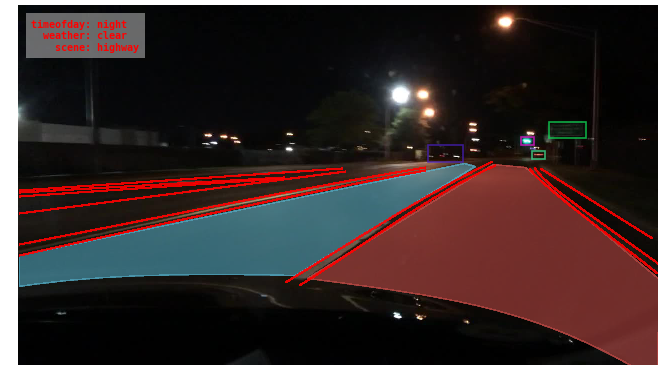

In [8]:
viewer.view()

Image: b1c81faa-c80764c5.jpg


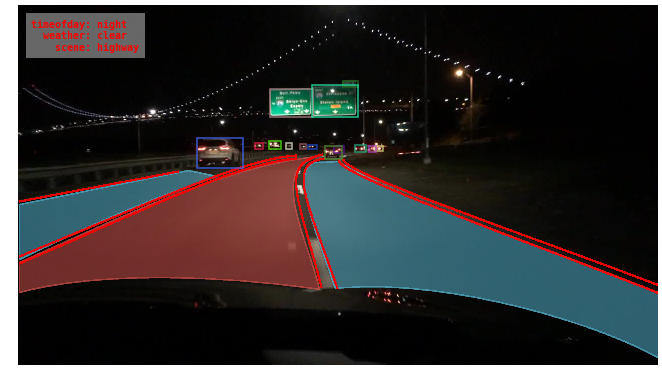

In [9]:
viewer.next_image('n')
viewer.view()

Image: b1d22449-117aa773.jpg


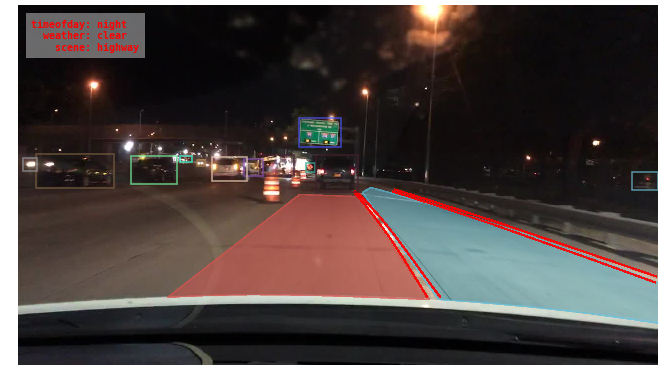

In [10]:
viewer.next_image('n')
viewer.view()

Image: b1e2346e-c5f98707.jpg


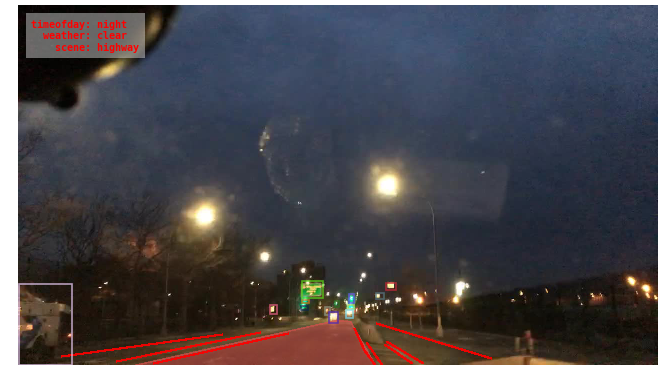

In [11]:
viewer.next_image('n')
viewer.view()

Image: b1e88fd2-c1e4fd2b.jpg


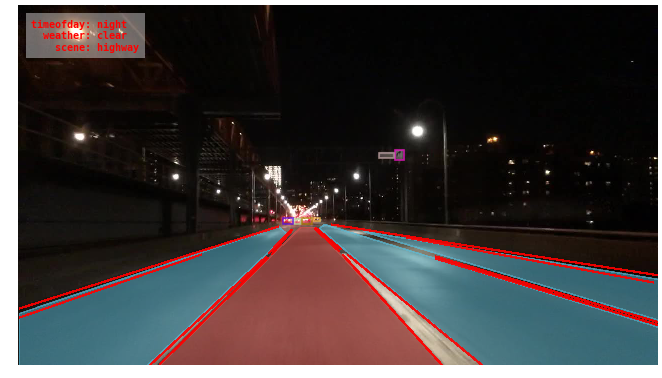

In [12]:
viewer.next_image('n')
viewer.view()

Image: b1f6c103-5ce1f3c6.jpg


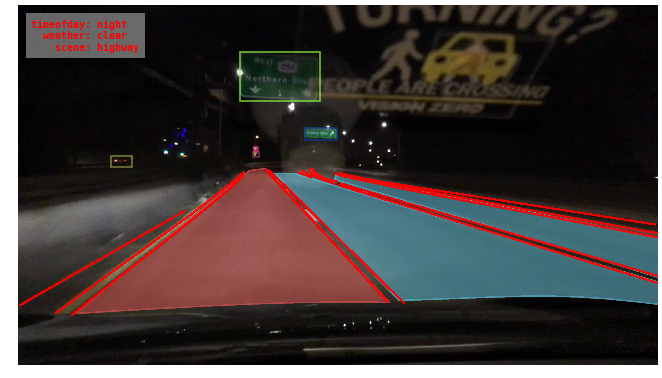

In [13]:
viewer.next_image('n')
viewer.view()

Image: b20eae11-18cd8ca2.jpg


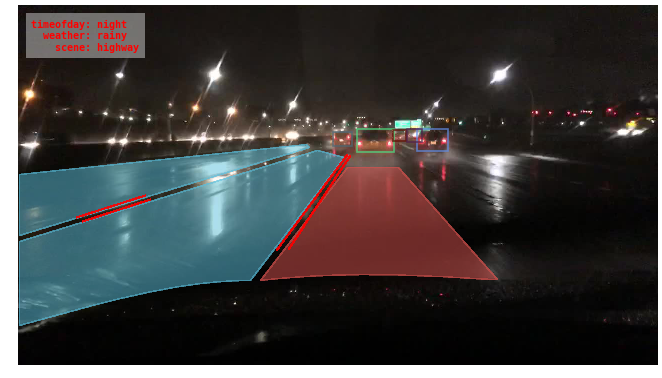

In [14]:
viewer.next_image('n')
viewer.view()

Image: b21ac8b3-9b9cb45a.jpg


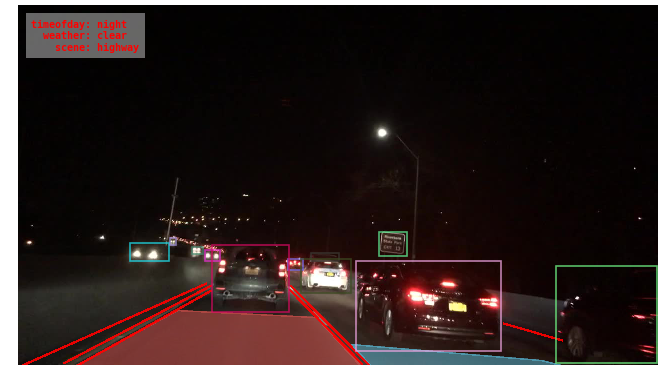

In [15]:
viewer.next_image('n')
viewer.view()

Image: b229488e-e4714bb7.jpg


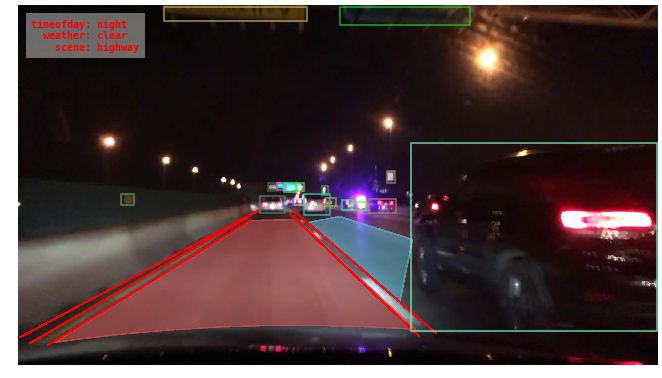

In [16]:
viewer.next_image('n')
viewer.view()